<a href="https://colab.research.google.com/github/GailB-ca/digital-display-reader/blob/main/Digit_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import pickle
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive


In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config):
    pass  # init sessin with allow_growth


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/training_df.pk"
training_numbers_df = pickle.load(open(filename, 'rb'))

In [ ]:
#training_numbers_df.head()

In [ ]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=False,
    fill_mode="nearest",
    validation_split=0.2)

testAug = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# Shuffle the rows
from sklearn.utils import shuffle
training_numbers_df = shuffle(training_numbers_df)

In [ ]:
X = np.array(training_numbers_df['img_num_arr_resize'].values.tolist())
Y = np.array(training_numbers_df['class_arr'].values.tolist())

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
X_train = tf.keras.applications.resnet50.preprocess_input(X_train)
Y_train = tf.keras.utils.to_categorical(Y_train)

X_test = tf.keras.applications.resnet50.preprocess_input(X_test)
Y_test = tf.keras.utils.to_categorical(Y_test)

In [ ]:
#learning_rate = 1e-6 # poor performance
learning_rate = 1e-4
#learning_rate = 1e-2 # Poor performance
num_epochs = 10
batch_size=16
#batch_size=24 # poor performance
#batch_size=12 # poor performance

In [ ]:
trainGen = trainAug.flow(X_train, Y_train, batch_size=batch_size, subset="training", shuffle=True)
valGen = trainAug.flow(X_train, Y_train, batch_size=batch_size, subset="validation", shuffle=True)
testGen = testAug.flow(X_test, Y_test, batch_size=batch_size)

In [ ]:
print("Size of Training Data: ", trainGen.n)

Size of Training Data:  695


In [ ]:
#baseModel = ResNet50(weights='imagenet', include_top=False,
baseModel = ResNet50(weights=None, include_top=True,
                    input_tensor=Input(shape=(600, 400, 3)),
                    classes=10)

In [ ]:
opt = Adam(lr=learning_rate, 
           decay=learning_rate / num_epochs)
baseModel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
print("Steps per epoch", trainGen.n // batch_size)
print("Number of epochs", num_epochs)
print("Validation data", valGen.n)

Steps per epoch 43
Number of epochs 10
Validation data 173


In [ ]:
train_history = baseModel.fit(trainGen,
                   steps_per_epoch=trainGen.n // batch_size, 
                   epochs=num_epochs,
                   validation_data=valGen,
                   validation_steps=valGen.n // batch_size,
                   verbose=1)

Epoch 1/10
43/43 [==============================] - 67s 1s/step - loss: 3.0465 - accuracy: 0.1739 - val_loss: 2.2605 - val_accuracy: 0.1813
Epoch 2/10
43/43 [==============================] - 44s 1s/step - loss: 2.2228 - accuracy: 0.2781 - val_loss: 2.4364 - val_accuracy: 0.1750
Epoch 3/10
43/43 [==============================] - 44s 1s/step - loss: 2.2489 - accuracy: 0.2639 - val_loss: 3.8860 - val_accuracy: 0.1688
Epoch 4/10
43/43 [==============================] - 44s 1s/step - loss: 2.0497 - accuracy: 0.3366 - val_loss: 4.9904 - val_accuracy: 0.1813
Epoch 5/10
43/43 [==============================] - 44s 1s/step - loss: 1.7531 - accuracy: 0.4127 - val_loss: 6.5464 - val_accuracy: 0.2000
Epoch 6/10
43/43 [==============================] - 43s 1s/step - loss: 1.5561 - accuracy: 0.4926 - val_loss: 7.0061 - val_accuracy: 0.1688
Epoch 7/10
43/43 [==============================] - 43s 1s/step - loss: 1.4919 - accuracy: 0.5173 - val_loss: 6.8652 - val_accuracy: 0.1688
Epoch 8/10
43/43 [==

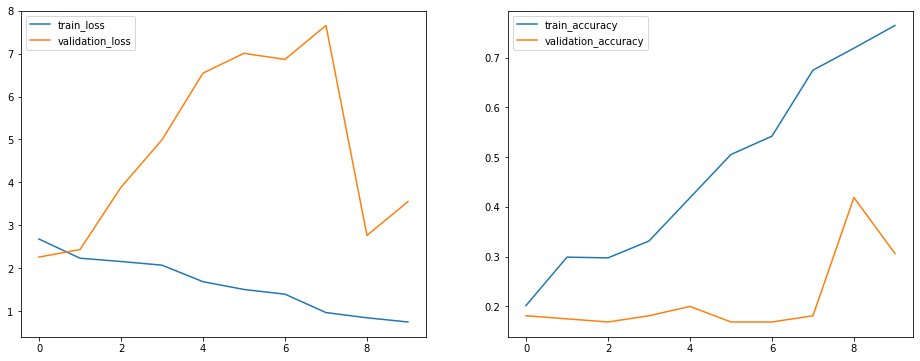

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(train_history.history['loss'], label='train_loss')
ax1.plot(train_history.history['val_loss'], label='validation_loss')
ax1.legend()
ax2.plot(train_history.history['accuracy'], label='train_accuracy')
ax2.plot(train_history.history['val_accuracy'], label='validation_accuracy')
ax2.legend();

In [ ]:
testGen.reset()
predIdxs = baseModel.predict(
    testGen,
	  steps=(testGen.n // batch_size) + 1)

In [ ]:
print(predIdxs)
predIdxs = np.argmax(predIdxs, axis=1)

[[9.3146986e-01 5.7554399e-03 2.8788642e-04 ... 1.6267740e-04
  3.6407562e-06 1.1639802e-05]
 [9.0610899e-02 2.3384766e-04 3.5075364e-01 ... 2.5232977e-03
  1.4201140e-04 1.3288342e-02]
 [5.4829627e-01 3.4401022e-02 2.9166331e-04 ... 1.4730946e-02
  4.5323650e-06 9.3720919e-05]
 ...
 [1.2384131e-01 2.8653002e-01 4.7781103e-04 ... 3.4655247e-02
  1.0251594e-05 7.5113901e-05]
 [6.3454406e-03 8.5504180e-01 7.5128762e-04 ... 3.1252820e-02
  1.6391628e-05 3.0734773e-05]
 [4.6428747e-02 4.8069302e-03 7.7332872e-01 ... 6.6244779e-03
  3.1916938e-05 5.8671357e-03]]


In [ ]:
from sklearn.metrics import classification_report
print(predIdxs)
Y_expected = np.argmax(Y_test, axis=1)
print(Y_expected)
print(classification_report(Y_expected, predIdxs, zero_division=0))	

[0 5 0 0 1 1 1 7 0 2 4 0 4 2 0 5 1 0 0 1 0 1 4 0 0 0 4 0 0 0 0 0 1 5 2 0 0
 5 2 0 0 0 1 1 1 0 1 5 1 0 0 0 0 0 0 4 1 1 1 4 4 0 1 0 0 2 4 0 5 5 1 1 0 0
 2 2 0 2 0 1 1 4 3 1 5 1 1 5 0 2 1 5 0 0 0 1 0 0 0 1 4 2 1 4 1 0 0 1 4 0 3
 0 5 7 4 0 1 5 2 1 0 1 3 5 0 0 1 4 0 1 0 4 0 0 1 5 4 5 1 0 0 4 1 1 2 1 0 2
 7 4 1 1 0 1 0 0 5 4 0 0 0 4 0 2 7 2 0 1 1 0 0 0 3 1 1 1 0 0 0 0 0 0 1 4 1
 0 4 0 2 0 1 4 0 1 7 1 1 7 0 0 0 0 0 2 0 7 1 0 0 4 0 0 0 2 2 4 1 2]
[1 6 2 9 7 1 6 7 8 4 1 1 5 4 2 2 7 7 3 8 4 9 6 9 7 8 9 1 7 1 2 7 5 1 5 3 6
 7 7 2 4 5 4 1 3 7 3 6 5 9 7 2 9 8 6 7 1 0 4 5 4 1 5 7 1 7 6 7 9 1 4 2 8 6
 5 2 1 6 7 3 3 0 2 6 1 1 6 4 2 5 6 3 1 2 0 5 2 7 7 1 7 9 7 1 7 2 7 6 1 0 5
 6 1 8 9 7 7 8 0 2 4 1 3 7 5 3 2 6 0 7 0 7 2 7 6 4 4 2 1 7 7 8 4 0 6 1 6 9
 3 9 1 1 2 7 2 2 1 9 5 6 1 5 4 4 1 5 8 4 4 6 0 1 6 0 0 0 8 5 7 7 1 7 6 2 2
 1 7 6 6 4 5 1 1 6 8 7 7 1 7 4 6 1 2 2 7 9 6 4 1 9 7 6 5 1 8 8 6 5]
              precision    recall  f1-score   support

           0       0.05      0.42      0.10        12
     